In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
sns.set_style("dark", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set_context("paper")
sns.set(font_scale = 2)

In [3]:
import sys
sys.path.append("../")

import utils as ut

In [4]:
meta_file = "/data5/deepro/starrseq/data/meta_data/metadata.json"
all_lib_names = ["input", "control", "atf2", "ctcf", "foxa1", "lef1", "scrt1", "tcf7l2", "16p12.1"]
store_dir = "/data5/deepro/starrseq/main_library/2_quality_control_lib/data/"

In [5]:
def read_and_extract_coverage(cov_bed):
    df = pd.read_csv(cov_bed, sep="\t", header=None)
    roi_depth = df.iloc[:, -4]
    return roi_depth

def plot_read_histogram(beds, ax):
    df = pd.concat(list(map(read_and_extract_coverage, beds)), axis=1)
    df.columns = [f"Rep {i}" for i in range(1, len(beds)+1)]
    percent_regions_gt_50_reads = int((((df>50).sum()/len(df)).min())*100)
    bins = list(np.linspace(0, 2000, 70))
    sns_ax = sns.histplot(data = df, bins=bins, ax=ax, legend=False)
    return sns_ax, percent_regions_gt_50_reads

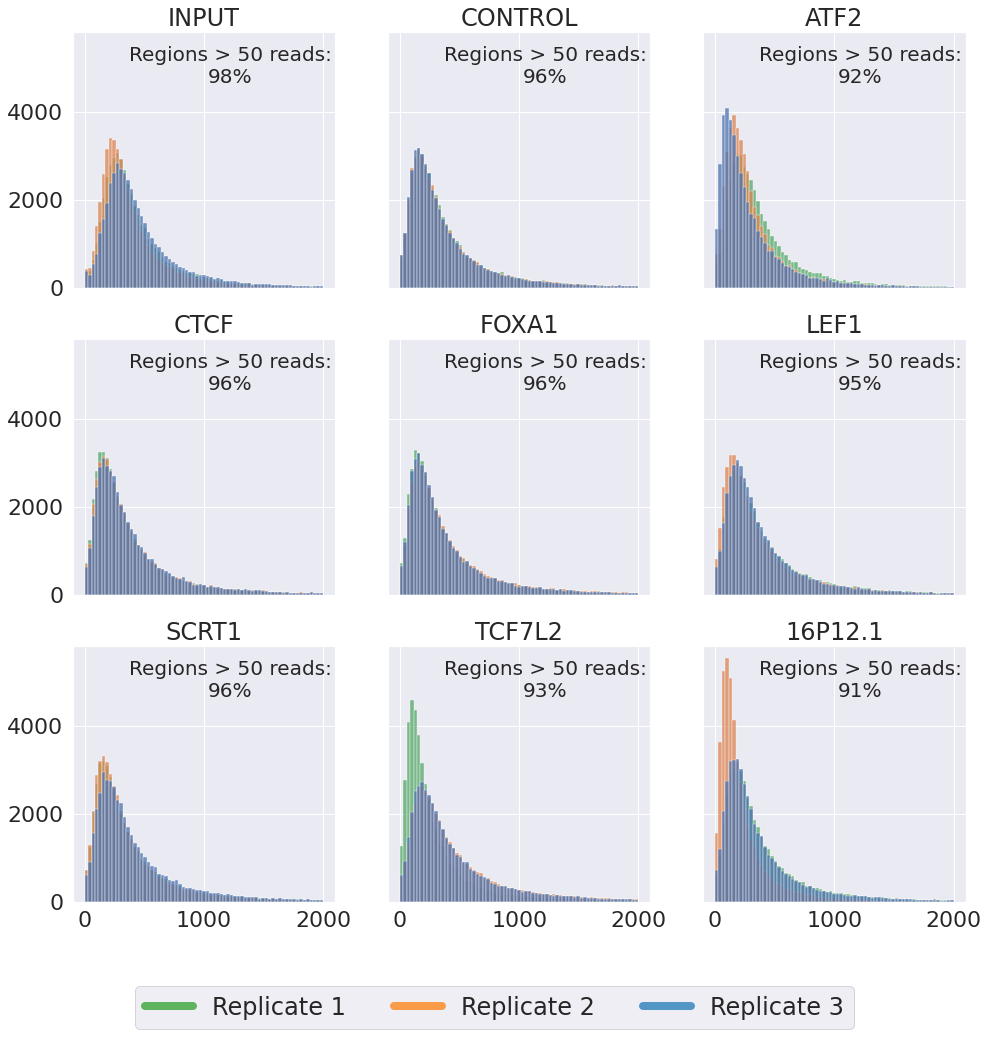

In [6]:
## create the subplot figure
all_lib_names_arr = np.array(all_lib_names).reshape(3,3)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16,16), sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        lib_name = all_lib_names_arr[i, j]
        lib_args = ut.create_args(meta_file, lib_name)
        lib_beds = ut.get_lib_depth_beds_filepaths(store_dir, lib_args.library_short, lib_args.library_prefix, lib_args.library_reps)
        sns_ax, per_gt_50 = plot_read_histogram(lib_beds, axes[i][j])
        sns_ax.set_title(lib_name.upper(), fontsize=24)
        sns_ax.set_ylabel("")
        # sns_ax.set_yticklabels([])
        # sns_ax.set_xticklabels([])
        axes[i][j].annotate(f"Regions > 50 reads:\n{per_gt_50}%", xy=(0.6,0.8), xycoords='axes fraction', ha='center', fontsize=20)

cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 0.75), lw=8),
                Line2D([0], [0], color=(1.0, 0.4980392156862745, 0.054901960784313725, 0.75), lw=8),
                Line2D([0], [0], color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.75), lw=8)]

fig.legend(custom_lines, ["Replicate 1", "Replicate 2", "Replicate 3"], loc="lower center", ncol=3, fontsize=24)

# Read depth box plots

In [7]:
def read_depth_df(lib_name):
    lib_args = ut.create_args(meta_file, lib_name)
    lib_beds = ut.get_lib_depth_beds_filepaths(store_dir, lib_args.library_short, lib_args.library_prefix, lib_args.library_reps)
    depth_df = pd.concat(list(map(read_and_extract_coverage, lib_beds)), axis=1).mean(axis=1).to_frame(name="read_depth")
    depth_df["library"] = lib_name
    return depth_df

In [8]:
depth_dfs = [read_depth_df(lib_name) for lib_name in all_lib_names]

In [9]:
depth_df = pd.concat(depth_dfs, axis=0)

In [16]:
depth_df.read_depth = np.log10(depth_df.read_depth)

/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


/data5/deepro/miniconda3/envs/starrseq/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


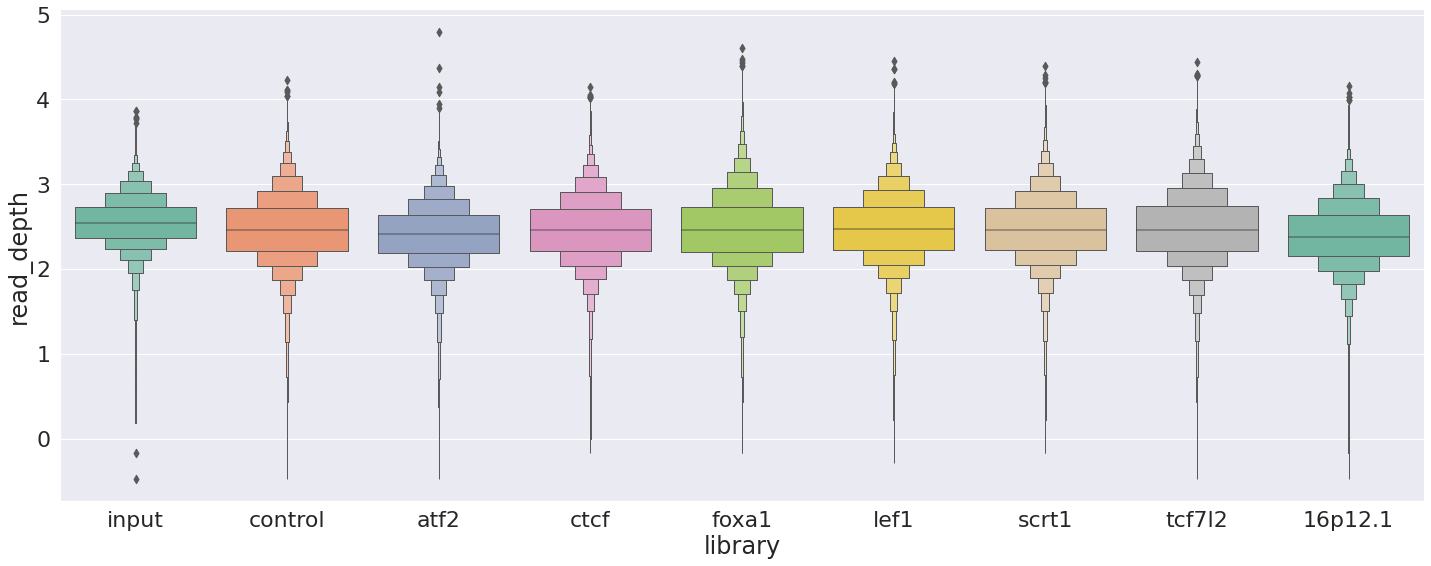

In [31]:
sns.catplot(data=depth_df, y="read_depth", x="library", palette="Set2", height=8, aspect=2.5, kind="boxen");